# Import


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from einops import rearrange
from torchvision.utils import make_grid

import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

import sys
import os
import numpy as np
import cv2
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
import json
from pprint import pprint

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))
import dataset as D
from diff_augment import DiffAugment
import lookup_dict as LD


# /n03452741/n03452741_17620. jpeg' different image?

# Dataset


In [2]:
root_path = "/home/choi/BrainDecoder/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")

config = {}
now = ""

In [3]:
dataset = D.EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        # DiffAugment(policy=config["diffaug-policy"]),
    ]
)

loaders = {
    split: DataLoader(
        dataset=D.EEGImageDataset(D.Splitter(dataset, split_name=split), transform),
        batch_size=config["batch-size"],
        shuffle=True if split == "train" else False,
        drop_last=True,
        num_workers=4,
    )
    for split in ["train", "val", "test"]
}

## eda

/home/choi/Downloads/miniconda3/envs/braindecoder/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


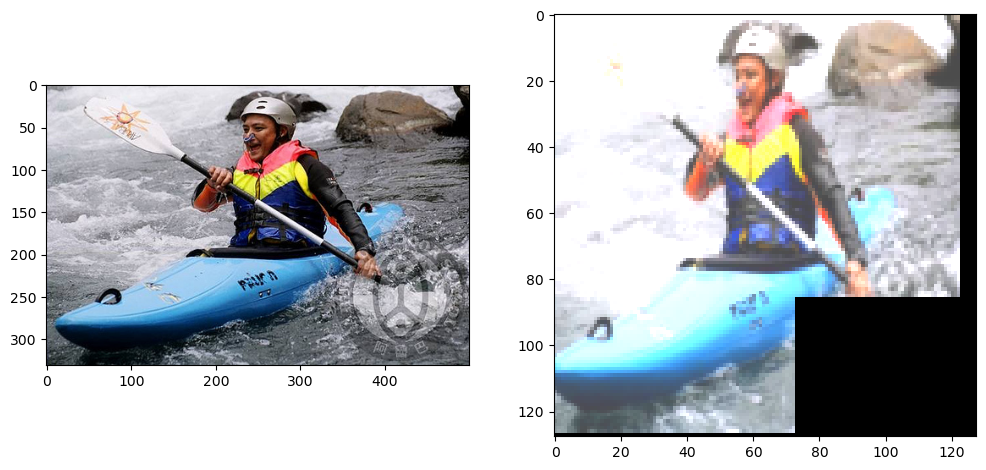

In [ ]:
# Testing
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        DiffAugment(policy=config["diffaug-policy"]),
    ]
)
eeg_img_dataset = D.EEGImageDataset(D.Splitter(dataset, split_name="train"), transform)
eeg_img_dataset_original = D.EEGImageDataset(D.Splitter(dataset, split_name="train"))

idx = 1
eeg, img = eeg_img_dataset[idx]
_, img_original = eeg_img_dataset_original[idx]

plt.figure(figsize=(12, 15))
plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.show()
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

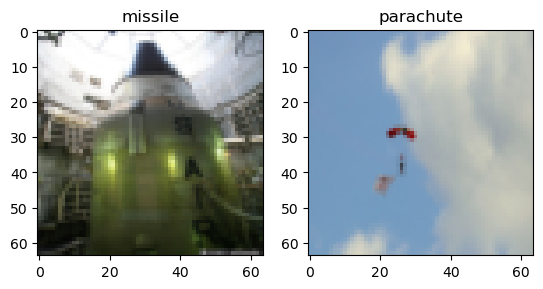

In [ ]:
idx = np.random.randint(loaders["test"].dataset.__len__())

eeg, label, img = loaders["test"].dataset.__getitem__(idx)
eeg2, label2, img2 = loaders["test"].dataset.__getitem__(idx + 10)

# print(img)
# print(img.shape)
# plt.imshow(img.permute(1, 2, 0))
# print(type(img))

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title(LD.id_to_name[LD.idx_to_id[label]])
ax[1].imshow(img2.permute(1, 2, 0))
ax[1].set_title(LD.id_to_name[LD.idx_to_id[label2]])

samples = []
samples.append(img)
samples.append(img2)

In [ ]:
from einops import rearrange
from torchvision.utils import make_grid
from PIL import Image

outdir = "/home/choi/BrainDecoder/outputs/samplelevelGAN"
os.makedirs(outdir, exist_ok=True)
grid_count = len(os.listdir(outdir))
print(grid_count)
grid = torch.stack(samples, 0)
# grid = rearrange(grid, "n b c h w -> (n b) c h w")
grid = make_grid(grid, nrow=2)

# to image
grid = 255.0 * rearrange(grid, "c h w -> h w c").cpu().numpy()
img = Image.fromarray(grid.astype(np.uint8))
# img = put_watermark(img, wm_encoder)
img.save(os.path.join(outdir, f"grid-{grid_count:04}.png"))

3


# Model


In [7]:
device = f"cuda:{config['gpu-id']}" if torch.cuda.is_available() else "cpu"
print(device)

cuda:1


In [8]:
class PixelLevelFeatureExtractorNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # Triplet loss
        # def dist_fn(x1, x2):
        #     return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=0)

        # self.loss_fn = nn.TripletMarginWithDistanceLoss(
        # distance_function=dist_fn, margin=config["margin"]
        # )

        # model
        self.input_size = 128
        self.hidden_size = config["lstm-hidden-size"]
        self.lstm_layers = config["lstm-layer"]
        self.out_size = 128

        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

    def forward(self, input):
        # with torch.no_grad():
        input = input.to(self.device)

        lstm_out, _ = self.lstm(input)
        res = self.output(lstm_out[:, -1, :])

        return res

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + 128, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(config["img-size"]))),
            nn.Tanh(),
        )

    def forward(self, noise, condition):
        # 과연...?
        # print("condition", condition)
        # print("noise", noise)
        gen_input = torch.cat((condition, noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *config["img-size"])
        return img

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config["img-size"])) + 128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, condition):
        # print(img.shape)  # torch.Size([16, 3, 128, 128])
        # print(condition.shape)  # torch.Size([16, 128])
        d_input = torch.cat((img.view(img.size(0), -1), condition), -1)
        validity = self.model(d_input)
        return validity

In [16]:
class saliency_map_GAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        # self.data_shape = (3, 32, 32)

        self.generator = Generator()
        self.discriminator = Discriminator()

        self.feature_extractor = PixelLevelFeatureExtractorNN.load_from_checkpoint(
            config["checkpoint"]
        )
        self.feature_extractor.requires_grad_(False)
        self.loss_fn = self.adversarial_loss

    def adversarial_loss(self, y_hat, y):
        # return F.binary_cross_entropy(y_hat, y)
        return F.mse_loss(y_hat, y)

    def forward(self, noise, condition):
        return self.generator(noise, condition)

    def training_step(self, batch, _):
        eegs, _, real_imgs = batch
        g_optim, d_optim = self.optimizers()

        batch_size = real_imgs.size(0)
        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        real_imgs = real_imgs.to(device)

        eeg_features = self.feature_extractor(eegs)

        y_real = torch.ones([batch_size, 1], device=device, requires_grad=False)
        y_fake = torch.zeros([batch_size, 1], device=device, requires_grad=False)

        #####################
        # generator training
        #####################
        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        g_loss = self.loss_fn(y_hat, y_real)

        # mode seeking loss
        # lz = torch.mean(torch.abs(self.fake_image2 - self.fake_image1)) / torch.mean(
        #     torch.abs(self.z_random2 - self.z_random)
        # )
        # eps = 1 * 1e-5
        # loss_lz = 1 / (lz + eps)

        g_optim.zero_grad()
        self.manual_backward(g_loss)
        g_optim.step()

        #########################
        # discriminator training
        #########################
        y_hat = self.discriminator(real_imgs, eeg_features)
        d_loss_real = self.loss_fn(y_hat, y_real)

        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        d_loss_fake = self.loss_fn(y_hat, y_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2

        d_optim.zero_grad()
        self.manual_backward(d_loss)
        d_optim.step()

        self.log_dict(
            {"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True, on_epoch=True
        )

    # def on_train_epoch_end(self) -> None:
    #     loaders["test"].dataset.__getitem__()
    #     return super().on_train_epoch_end()

    def validation_step(self, batch, batch_idx):
        if batch_idx > 0:
            return
        # save images
        eegs, _, real_imgs = batch

        batch_size = real_imgs.size(0)
        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        real_imgs = real_imgs.to(device)

        eeg_features = self.feature_extractor(eegs)
        gen_imgs = self.generator(noise, eeg_features)

        outputs = [real_imgs, gen_imgs]

        save_dir = f"/home/choi/BrainDecoder/lightning_logs/SaliencyMapGAN/{now}/version/output_imgs"
        os.makedirs(save_dir, exist_ok=True)
        grid_count = len(os.listdir(save_dir))

        grid = torch.stack(outputs, 0)
        grid = rearrange(grid, "n b c h w -> (n b) c h w")
        grid = make_grid(grid, nrow=batch_size)

        # to image
        grid = 255.0 * rearrange(grid, "c h w -> h w c").cpu().numpy()
        img = Image.fromarray(grid.astype(np.uint8))
        img.save(
            os.path.join(
                save_dir, f"grid_{grid_count:04}-epoch_{self.current_epoch}.png"
            )
        )

    # def on_validation_epoch_end(self):
    #     print("HI")

    def test(self, eeg):
        noise = torch.randn(1, 100)
        eeg = eeg.unsqueeze(dim=0)
        condition = self.feature_extractor(eeg)

        noise = noise.to(device)
        condition = condition.to(device)

        return self.forward(noise, condition)

    def configure_optimizers(self):
        g_optim = optim.Adam(
            self.generator.parameters(), lr=config["lr"], betas=(0.9, 0.999)
        )
        d_optim = optim.Adam(
            self.discriminator.parameters(), lr=config["lr"], betas=(0.9, 0.999)
        )
        g_scheduler = optim.lr_scheduler.LambdaLR(
            g_optim, lambda epoch: config["lambda-factor"] ** epoch
        )
        d_scheduler = optim.lr_scheduler.LambdaLR(
            d_optim, lambda epoch: config["lambda-factor"] ** epoch
        )
        return [g_optim, d_optim], [g_scheduler, d_scheduler]
        # return [g_optim, d_optim], []

# Training


In [19]:
def set_config():
    global config
    config = {
        "batch-size": 16,
        "lr": 2e-4,
        "lambda-factor": 0.975,
        "gpu-id": 1,
        "lstm-hidden-size": 128,
        "lstm-layer": 2,
        "img-size": (3, 64, 64),
        "diffaug-policy": "color,translation,cutout",
        "generate-image-every-n-epoch": 5,
        "save-checkpoint-every-n-epoch": 10,
        "checkpoint": "/home/choi/BrainDecoder/lightning_logs/PixelLevelFeatureExtraction/2024-01-11 21:32:49/version/checkpoints/epoch=647_val_loss=0.0000.ckpt",
    }


set_config()

## Train

In [20]:
model = saliency_map_GAN()
model.to(device)
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("===========================")
pprint(config)
print(now)
print("===========================")


logger = TensorBoardLogger(
    save_dir="/home/choi/BrainDecoder/lightning_logs/SaliencyMapGAN/",
    name=f"{now}",
    version="version",
)

# Writing to sample.json
os.makedirs(
    f"/home/choi/BrainDecoder/lightning_logs/SaliencyMapGAN/{now}/version",
    exist_ok=True,
)
config_json = json.dumps(config, indent=4)
with open(
    f"/home/choi/BrainDecoder/lightning_logs/SaliencyMapGAN/{now}/version/config.json",
    "w+",
) as outfile:
    outfile.write(config_json)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
ckpt_callback = ModelCheckpoint(
    save_top_k=-1,
    # monitor="g_loss",
    # mode="min",
    every_n_epochs=config["save-checkpoint-every-n-epoch"],
    save_last=True,
    filename="{epoch}_{g_loss:.4f}_{d_loss:.4f}",
)

trainer = L.Trainer(
    max_epochs=1000,
    logger=logger,
    callbacks=[lr_monitor, ckpt_callback],
    accelerator="gpu",
    devices=[config["gpu-id"]],
    check_val_every_n_epoch=config["generate-image-every-n-epoch"],
    num_sanity_val_steps=1,
)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | generator         | Generator                    | 13.3 M
1 | discriminator     | Discriminator                | 6.5 M 
2 | feature_extractor | PixelLevelFeatureExtractorNN | 280 K 
-------------------------------------------------------------------
19.8 M    Trainable params
280 K     Non-trainable params
20.1 M    Total params
80.351    Total estimated model params size (MB)


{'batch-size': 16,
 'checkpoint': '/home/choi/BrainDecoder/lightning_logs/PixelLevelFeatureExtraction/2024-01-11 '
               '21:32:49/version/checkpoints/epoch=647_val_loss=0.0000.ckpt',
 'diffaug-policy': 'color,translation,cutout',
 'generate-image-every-n-epoch': 5,
 'gpu-id': 1,
 'img-size': (3, 64, 64),
 'lambda-factor': 0.975,
 'lr': 0.0002,
 'lstm-hidden-size': 128,
 'lstm-layer': 2,
 'save-checkpoint-every-n-epoch': 10}
2024-02-06 02:03:49


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Testing


In [84]:
def test(model, eeg, img):
    model.eval()
    gen_img = model.test(eeg)
    model.train()
    gen_img = gen_img.squeeze(dim=0).cpu().detach()

    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(gen_img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


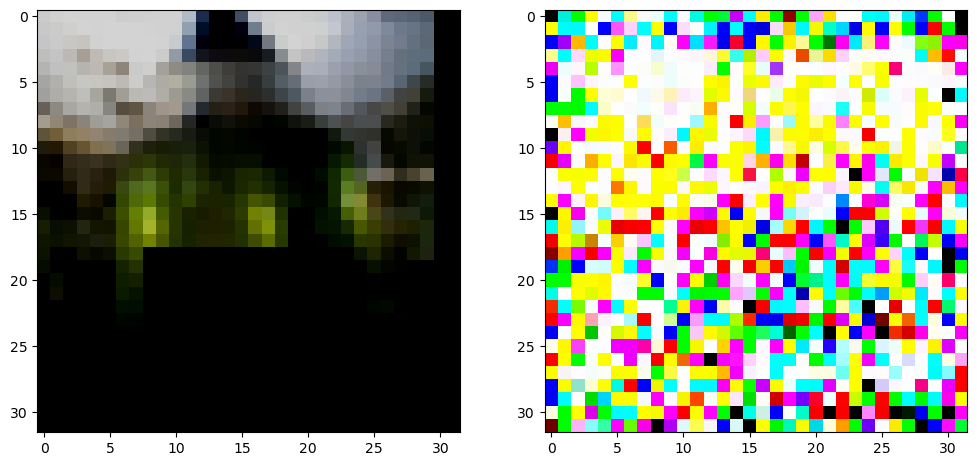

In [100]:
eeg, _, img = loaders["test"].dataset[4]

test(model, eeg, img)

# Test with checkpoint


In [40]:
CKPT_PATH = "/Users/ms/cs/ML/BrainDecoder/lightning_logs/SaliencyMapGAN/2023-12-07 21:11:09/checkpoints/epoch=2-step=2988.ckpt"

In [41]:
# try output one image from one random eeg. show generated image, original image
model = saliency_map_GAN.load_from_checkpoint(CKPT_PATH)
model.to(device)

RuntimeError: Error(s) in loading state_dict for saliency_map_GAN:
	size mismatch for generator.model.11.weight: copying a param with shape torch.Size([49152, 1024]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for generator.model.11.bias: copying a param with shape torch.Size([49152]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for discriminator.model.0.weight: copying a param with shape torch.Size([512, 49280]) from checkpoint, the shape in current model is torch.Size([512, 3200]).

In [181]:
eeg, _, img = loaders["test"].dataset[20]

test(model, eeg, img)

RuntimeError: Placeholder storage has not been allocated on MPS device!